In [1]:
import os
import sys

sys.path.append(os.path.join(os.getcwd(), 'monitor'))

from monitor import *

## Tensorflow log level currently set to 1 (ERROR), reduce to supress tensorflow logs

### Declare parameters (see parameters.py)

In [2]:
# monitor parameters
TRANSF = [0, 0.2, 0.5, 0.8, 1]
ACC_BOUNDS = [0.70, 0.40]
K_FOLDS = 3

# in- and output directories
DATA_DIR = 'transformations'
MODEL_DIR = 'models'

# target dataset and model for the monitor
DATASET = 'gtsrb'
MODEL = 'model3b.h5'

In [ ]:
DATA_PATH = os.path.join(os.path.dirname(__file__), '..', 'data')

### Generate degraded datasets based on combinations of transformations

In [4]:
## gen_datasets_from_transforms, in combineTransform.py

# hard coding number of influencing factors for now
alltransf = [TRANSF]*3
comb_prod = combinatorial_transf(alltransf)
# preparing for option to train on CIFAR too
if DATASET == 'gtsrb': 
    [X_train, y_train, X_test, y_test, labels] = load_gtsrb()

comb_prod[:5]

[[0, 0, 0], [0, 0, 0.2], [0, 0, 0.5], [0, 0, 0.8], [0, 0, 1]]

In [4]:
## example dataset, uses functions in trasform.py (pulled from DeepCERT repo) to transform data
test_degrade = create_dataset(
    data=X_test,
    transf=comb_prod[42]
)

- This cell generates all datasets and saves them under 'transformations'

In [5]:
# createalldatasets(
#    data=X_test,
#    allcombtransf=comb_prod,
#    out_dir=DATA_DIR)

### Test model on degraded datasets and generate labels based on accuracy class

In [6]:
## labelData
model = tf.keras.models.load_model(os.path.join(MODEL_DIR, DATASET, MODEL))

- This cell creates an array of values describing accuracy of the model for each degraded dataset generated earlier
- (Needs adjustments to function if accuracy has already been generated)

In [8]:
acc_path = os.path.join(DATA_DIR, 'accuracy.npy')

if not os.path.isfile(acc_path):
    print(y_test)
    acc = computePerformance(
        model=model,
        data_dir=DATA_DIR,
        labels=y_test)
    np.save(os.path.join(DATA_DIR, 'accuracy'), acc)
else: acc = np.load(acc_path)

print(acc)

[0.98004866 0.94330901 0.7021898  0.50900245 0.41484186 0.97493917
 0.93941605 0.69051093 0.49270073 0.40048662 0.95109487 0.91484183
 0.66739661 0.44817519 0.356691   0.48686132 0.52895379 0.38442823
 0.24817519 0.19270073 0.14744526 0.15109488 0.14549878 0.15425791
 0.14768857 0.95912409 0.96715331 0.94403893 0.66593677 0.4888078
 0.95036495 0.95936739 0.93795621 0.6435523  0.46204379 0.89635038
 0.92725062 0.91557175 0.5973236  0.39124086 0.40583941 0.4513382
 0.54574209 0.35888079 0.23479319 0.13381995 0.14257908 0.17372262
 0.16399027 0.17445256 0.81021899 0.83892941 0.82506084 0.49781021
 0.18248175 0.78783453 0.81240875 0.79829681 0.47931874 0.18248175
 0.7114355  0.72287107 0.71411192 0.43698296 0.18248175 0.27785888
 0.29197079 0.30291972 0.21703163 0.18248175 0.18321168 0.18321168
 0.19099757 0.18540145 0.18248175 0.44330901 0.30705595 0.18248175
 0.18248175 0.18248175 0.41192213 0.28832117 0.18248175 0.18248175
 0.18248175 0.33454987 0.23844282 0.18248175 0.18248175 0.182481

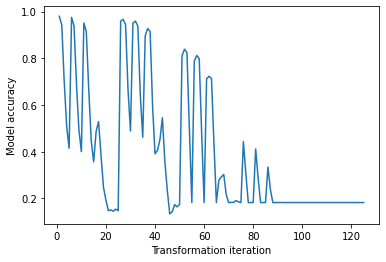

In [13]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(1, 126), acc)
plt.xlabel('Transformation iteration')
plt.ylabel('Model accuracy')
plt.show()

- This cell saves accuracy class labels for each degraded dataset

In [27]:
lab_path = os.path.join(DATA_DIR, 'labDatasets.npy')

if not os.path.isfile(lab_path):
    labels = np.array(ACC_BOUNDS)
    labData = labelDataset(acc, labels)
    print(labData[0][1])
    np.save(os.path.join(DATA_DIR, 'labDatasets'), labData)
else:
    labData = np.load(lab_path)

print(labData)

[[0.98004866 0.        ]
 [0.94330901 0.        ]
 [0.7021898  0.        ]
 [0.50900245 1.        ]
 [0.41484186 1.        ]
 [0.97493917 0.        ]
 [0.93941605 0.        ]
 [0.69051093 1.        ]
 [0.49270073 1.        ]
 [0.40048662 1.        ]
 [0.95109487 0.        ]
 [0.91484183 0.        ]
 [0.66739661 1.        ]
 [0.44817519 1.        ]
 [0.356691   2.        ]
 [0.48686132 1.        ]
 [0.52895379 1.        ]
 [0.38442823 2.        ]
 [0.24817519 2.        ]
 [0.19270073 2.        ]
 [0.14744526 2.        ]
 [0.15109488 2.        ]
 [0.14549878 2.        ]
 [0.15425791 2.        ]
 [0.14768857 2.        ]
 [0.95912409 0.        ]
 [0.96715331 0.        ]
 [0.94403893 0.        ]
 [0.66593677 1.        ]
 [0.4888078  1.        ]
 [0.95036495 0.        ]
 [0.95936739 0.        ]
 [0.93795621 0.        ]
 [0.6435523  1.        ]
 [0.46204379 1.        ]
 [0.89635038 0.        ]
 [0.92725062 0.        ]
 [0.91557175 0.        ]
 [0.5973236  1.        ]
 [0.39124086 2.        ]


### Select and prepare labelled datasets from each class for training

In [29]:
# specifies the number of influencing factors (could be parameterised later)
numClasses = 3 
# count number of datasets in each accuracy class
count = countSamplesClasses(
    labData=labData,
    numClasses=numClasses
)
print(count)

[25. 22. 78.]


#### this should all be refactored


In [30]:
# this gets indexes of datasets that match the specified accuracy class
ind1 = findIndexes(labData, 0)
ind2 = findIndexes(labData, 1)
ind3 = findIndexes(labData, 2)

In [34]:
# specify number of training and test sets (should go in parameters)
ntrainind = 10
ntestind = 2

# randomly sample $ntrainind$ training datasets and $ntestind$ test datasets from our data
[indexestr1, indexestest1] = findsamples(ind1, ntrainind, ntestind)
[indexestr2, indexestest2] = findsamples(ind2, ntrainind, ntestind)
[indexestr3, indexestest3] = findsamples(ind3, ntrainind, ntestind)

print(indexestr1)
print(indexestest1)

[ 5 30 36 11 27 62 61 51 25 31]
[ 1 60]


In [ ]:
# concatenate samples taken from datasets across accuracy classes
trainind = np.concatenate((indexestr1, indexestr2, indexestr3))
testind = np.concatenate((indexestest1, indexestest2, indexestest3))
imtr1 = concSamples(indexestr1)
imtr2 = concSamples(indexestr2)
imtr3 = concSamples(indexestr3)
labeltr1 = np.zeros(len(imtr1))
labeltr2 = np.ones(len(imtr2))
labeltr3 = np.zeros(len(imtr3))
for i in range(len(imtr3)):
    labeltr3[i] = 2
imtest1 = concSamples(indexestest1)
imtest2 = concSamples(indexestest2)
imtest3 = concSamples(indexestest3)
labeltest1 = np.zeros(len(imtest1))
labeltest2 = np.ones(len(imtest2))
labeltest3 = np.zeros(len(imtest3))
for i in range(len(imtest3)):
    labeltest3[i] = 2
trainX = np.concatenate((imtr1, imtr2, imtr3))
trainY = to_categorical(np.concatenate((labeltr1, labeltr2, labeltr3)))
testX = np.concatenate((imtest1, imtest2, imtest3))
testY = to_categorical(np.concatenate((labeltest1, labeltest2, labeltest3)))
shuffle_arrays([trainX, trainY])
shuffle_arrays([testX, testY])
data = [trainX, trainY, testX, testY]
indexes = [trainind, testind]

# pickle the datasets and indexes
with open('data.pickle', 'wb') as f:
    pickle.dump(data, f)
with open('indexes.pickle', 'wb') as f:
    pickle.dump(indexes, f)

### Train the monitor

In [1]:
## overview of the model used for the monitor
def create_model():
    return tf.keras.Sequential(
        [
            tf.keras.Input(shape=(32, 32, 3)),
            tf.keras.layers.Conv2D(16, 3, activation='relu'),
            tf.keras.layers.Conv2D(32, 3, activation='relu'),
            tf.keras.layers.Conv2D(64, 3, activation='relu'),
            tf.keras.layers.Conv2D(128, 3, activation='relu'),
            tf.keras.layers.Conv2D(256, 3, activation='relu'),
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(3, activation='softmax')
        ]
    )

In [2]:
## this function needs to be adjusted for correct parameterisation of k_fold
trainMonitor(
    model_dir=MODEL_DIR,
    k_fold=3,
    train=False)

2023-10-15 21:43:19.478300: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-10-15 21:43:19.478495: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Test Set
(24660, 32, 32, 3)
(24660, 3)


2023-10-15 21:43:19.859342: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 303022080 exceeds 10% of free system memory.
2023-10-15 21:43:20.075368: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-10-15 21:43:20.075602: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3600520000 Hz


771/771 [==============================] - 35s 45ms/step - loss: 0.4668 - categorical_accuracy: 0.8420
[0.4608250856399536, 0.8427818417549133]
  3/771 [..............................] - ETA: 34s - loss: 0.1495 - categorical_accuracy: 0.9479

2023-10-15 21:43:55.508401: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 303022080 exceeds 10% of free system memory.


771/771 [==============================] - 35s 46ms/step - loss: 0.2227 - categorical_accuracy: 0.9173
[0.22266189754009247, 0.9173154830932617]
  2/771 [..............................] - ETA: 41s - loss: 0.1125 - categorical_accuracy: 0.9844

2023-10-15 21:44:31.097964: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 303022080 exceeds 10% of free system memory.


771/771 [==============================] - 36s 46ms/step - loss: 0.1643 - categorical_accuracy: 0.9374
[0.1642969846725464, 0.9373884797096252]
